# Assignment 8
# RCES
# Yianna Bekris
# 04/09/2024

In [149]:
import xarray as xr
import matplotlib.pyplot as plt
import pooch
import numpy as np
import pandas as pd
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fname = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc"


In [54]:
# Reproduce the SST curve from the figure below
# Load the data as an Xarray dataset. Drop the time_bnds variable 
# as we did in class and trim the data to 1950 onward for this assignment.
sst_ds = xr.open_dataset(fname, drop_variables='time_bnds')

In [55]:
sst_ds = sst_ds.sel(time=slice('1950', None))
sst_ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 891)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2024-03-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes: (12/39)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    data_modified:                   2024-04-03
    DODS_EXTRA.Unlimited_Dimension:  time

In [56]:
lat_range = slice(5, -5)
lon_range = slice(190, 240)

# Slice the data array to select the Niño 3.4 region
nino34 = sst_ds.sel(lat=lat_range, lon=lon_range)
nino34

<xarray.Dataset>
Dimensions:  (lat: 5, lon: 26, time: 891)
Coordinates:
  * lat      (lat) float32 4.0 2.0 0.0 -2.0 -4.0
  * lon      (lon) float32 190.0 192.0 194.0 196.0 ... 234.0 236.0 238.0 240.0
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2024-03-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes: (12/39)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    data_modified:                   2024-04-03
    DODS_EXTRA.Unlimited_Dimension:  time

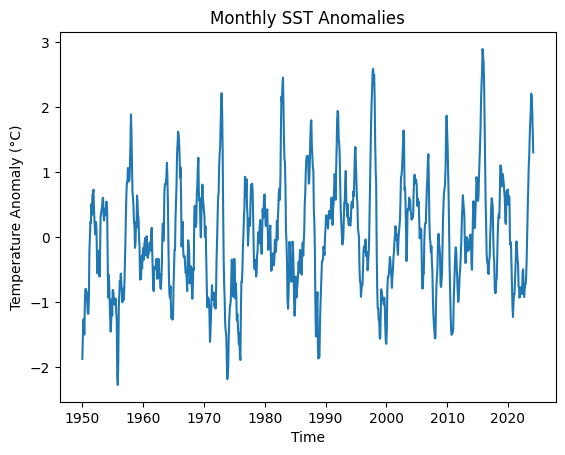

In [57]:
# Now calculate the climatology and the SST anomaly.
gb = nino34.sst.groupby('time.month')
anom = gb - gb.mean(dim='time')
anom.mean(dim=('lat','lon')).plot()

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly (°C)')
plt.title('Monthly SST Anomalies')

# Show the plot
plt.show()

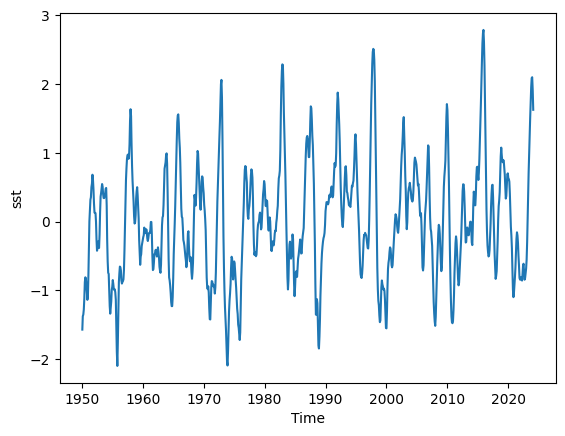

In [58]:
# Now reproduce the plot. Keep the rolling 3-month average of the SST anomaly 
# as a DataArray for the next question.
rolled_anom = anom.rolling(time=3, center=True).mean()
rolled_anom_mean = rolled_anom.mean(dim=('lat','lon'))
rolled_anom_mean.plot();

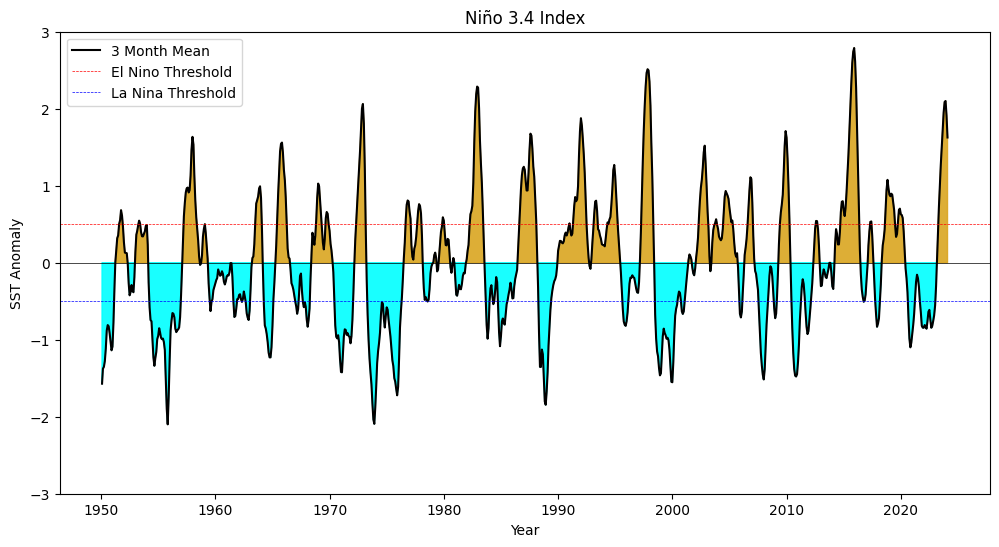

In [59]:
# Now reproducing the plot
# Credit to https://foundations.projectpythia.org/core/xarray/enso-xarray.html
# This helped me figure out how to plot this part
fig = plt.figure(figsize=(12, 6))

plt.fill_between(
    rolled_anom_mean.time.data,
    rolled_anom_mean.where(
        rolled_anom_mean > 0
    ).data,
    0,
    color='goldenrod',
    alpha=0.9,
)
plt.fill_between(
    rolled_anom_mean.time.data,
    rolled_anom_mean.where(
        rolled_anom_mean < 0
    ).data,
    0,
    color='cyan',
    alpha=0.9,
)

rolled_anom_mean.plot(color='black', label='3 Month Mean')
plt.axhline(0, color='black', lw=0.5)
plt.axhline(0.5, color='red', linewidth=0.5, linestyle='dashed', label='El Nino Threshold')
plt.axhline(-0.5, color='blue', linewidth=0.5, linestyle='dashed', label='La Nina Threshold')
plt.legend()
plt.ylim(-3,3)
plt.ylabel('SST Anomaly')
plt.xlabel('Year')
plt.title('Niño 3.4 Index');

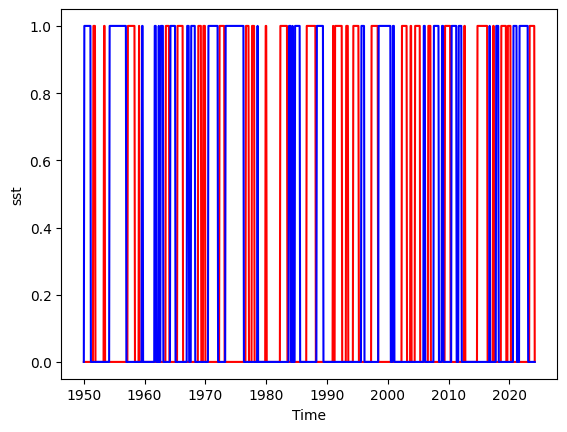

In [167]:
# Calculate boolean timeseries representing the positive / negative ENSO phases
elnino_mask = rolled_anom_mean >= 0.5
lanina_mask = rolled_anom_mean <= -0.5

elnino_mask.plot(color='red')
lanina_mask.plot(color='blue')

/tmp/ipykernel_207252/670191361.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


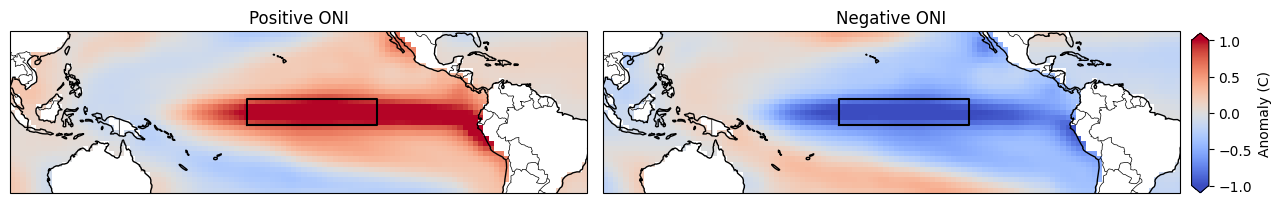

In [166]:
# Plot composites of SST anomaly for the positive and negative ENSO regimes
lat_range = slice(30, -30)
lon_range = slice(100, 320)

# Slice the data array to select the Niño 3.4 region
nino34_more = sst_ds.sel(lat=lat_range, lon=lon_range)
gb_more = nino34_more.sst.groupby('time.month')
anom_more = gb_more - gb_more.mean(dim='time')
rolled_anom_more = anom_more.rolling(time=3, center=True).mean()

elnino = rolled_anom_more.where(elnino_mask, drop=True)
lanina = rolled_anom_more.where(lanina_mask, drop=True)

plt.figure(figsize=(12,6))

ax1 = plt.subplot(1,2,1, projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_title('Positive ONI')
p1=ax1.pcolormesh(elnino.lon, elnino.lat,
               elnino.mean(dim='time'), 
               cmap='coolwarm', vmin=-1, vmax=1,
               transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
ax1.add_feature(cartopy.feature.COASTLINE, zorder=1)
ax1.plot([190, 240, 240, 190, 190], [-5, -5, 5, 5, -5],
         color='black',
         transform=ccrs.PlateCarree())

ax2 = plt.subplot(1,2,2, projection=ccrs.PlateCarree(central_longitude=180))
ax2.set_title('Negative ONI')
p2=ax2.pcolormesh(lanina.lon, lanina.lat,
               lanina.mean(dim='time'),
               cmap='coolwarm', vmin=-1, vmax=1,
               transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
ax2.add_feature(cartopy.feature.COASTLINE, zorder=1)
ax2.plot([190, 240, 240, 190, 190], [-5, -5, 5, 5, -5],
         color='black',
         transform=ccrs.PlateCarree())

axins = inset_axes(ax2, width = "3%", height = "99%", loc = 'lower left',
                   bbox_to_anchor = (1.02, 0., 1, 1), bbox_transform = ax2.transAxes,
                   borderpad = 0)

plt.colorbar(p2, ax=ax2, cax=axins, orientation='vertical', extend='both', label='Anomaly (C)')

plt.tight_layout()

In [102]:
# Calculate the composite of precipitation for positive and negative ENSO phases
url = 'http://iridl.ldeo.columbia.edu/SOURCES/.NASA/.GPCP/.V2p1/.multi-satellite/.prcp/dods'
dsp = xr.open_dataset(url, decode_times=False)
true_time = (pd.date_range(start='1960-01-01', periods=len(dsp['T']), freq='MS'))
dsp['T'] = true_time
dsp = dsp.rename({'T': 'time'})
dsp.load()

<xarray.Dataset>
Dimensions:  (Y: 72, X: 144, time: 356)
Coordinates:
  * Y        (Y) float32 88.75 86.25 83.75 81.25 ... -81.25 -83.75 -86.25 -88.75
  * X        (X) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 1989-08-01
Data variables:
    prcp     (time, Y, X) float32 nan nan nan nan ... 0.6489 0.6437 0.636 0.6303
Attributes:
    Conventions:  IRIDL

In [109]:
# Slice data to the same as the precip dataset for masking
rolled_anom_1960 = rolled_anom_mean.sel(time=slice('1960-01-01', '1989-08-01'))
elnino_mask_1960 = rolled_anom_1960 >= 0.5
lanina_mask_1960 = rolled_anom_1960 <= -0.5

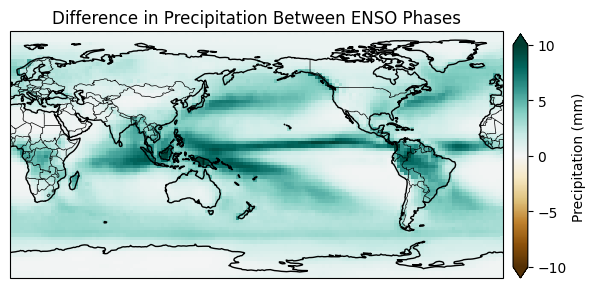

In [165]:
# Now plot the difference between the time-mean of prcp during positive and negative ENSO phases.
precip_elnino = dsp.where(elnino_mask_1960, drop=True)
precip_lanina = dsp.where(lanina_mask_1960, drop=True)

plt.figure(figsize=(14,8))

prcp_diff = precip_elnino.prcp.mean(dim='time') - precip_lanina.prcp.mean(dim='time')

ax1 = plt.subplot(1,2,1, projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_title('Difference in Precipitation Between ENSO Phases')
pcm = ax1.pcolormesh(precip_elnino.X, precip_elnino.Y,
               precip_elnino.prcp.mean(dim='time'),
               vmin=-10, vmax=10,
               cmap='BrBG',
               transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
ax1.add_feature(cartopy.feature.COASTLINE, zorder=1)

axins = inset_axes(ax1, width = "3%", height = "99%", loc = 'lower left',
                   bbox_to_anchor = (1.02, 0., 1, 1), bbox_transform = ax1.transAxes,
                   borderpad = 0)

plt.colorbar(pcm, ax=ax1, cax=axins, orientation='vertical', extend='both', label='Precipitation (mm)');